# Reading Single Day of Data

Getting things set up

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as mpl
from bokeh import palettes
from bokeh.charts import Bar
import math
from IPython.display import Image
import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [4]:
%matplotlib inline

The below file is a sample day of data stored as an HDF5 file. It can be read as a DataFrame.

In [13]:
day_file = r'/Users/lukestarnes/ADSB/h5/2016-10-01.h5'
mega_file = r'/Users/lukestarnes/ADSB/h5/mega8.h5'

In [14]:
store = pd.HDFStore(mega_file)

In [15]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/lukestarnes/ADSB/h5/mega8.h5
/data            frame_table  (typ->appendable,nrows->15815836,ncols->6,indexers->[index])

**How many rows are in the file?**

In [16]:
store.get_storer('data').nrows

15815836

**Read H5 as DF**

In [17]:
store_day = pd.HDFStore(day_file)
day_data_df = store_day.select('data', where=['Lat>=-90','Lat<=90','Long>=-180','Long<=180'])

In [18]:
mega_data_df = store.select('data')

In [11]:
def fx(t):
    try:
        return dt.datetime.fromtimestamp(t / 1000)
    except:
        return 0
mega_data_df['RealTime'] = mega_data_df['PosTime'].fillna(0).map(int).map(fx)
day_data_df['RealTime'] = day_data_df['PosTime'].fillna(0).map(int).map(fx)

**And how many unique aircraft reports?**

In [19]:
len(day_data_df['Icao'].unique()), len(mega_data_df['Icao'].unique())

(8511, 8885)

**How many different Operators and Manufacturers and Types of Aircraft?**

In [20]:
print('Unique Operators:', len(day_data_df['OpIcao'].unique()), 
      ' || Top 5:',list(day_data_df['OpIcao'].value_counts().keys()[:5]))
print('Unique Manufacturers:', len(day_data_df['Man'].unique()), 
      ' || Top 5:',list(day_data_df['Man'].value_counts().keys()[:5]))
print('Unique Type Designatios:', len(day_data_df['Type'].unique()),
      ' || Top 5:',list(day_data_df['Type'].value_counts().keys()[:5]))

Unique Operators: 426  || Top 5: ['SWA', 'AAL', 'UAL', 'DAL', 'JBU']
Unique Manufacturers: 122  || Top 5: ['Boeing', 'Airbus', 'Embraer', 'Bombardier', 'Cessna']
Unique Type Designatios: 288  || Top 5: ['B738', 'A320', 'B737', 'A321', 'A319']


## Airfraft Manufacturers 

**Here are the top aircraft manufacturers.**

In [21]:
ac_by_man = pd.pivot_table(mega_data_df,values=['Icao'],index='Man', 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)
mfr = ac_by_man.index[:10]
print('Total number of manufactuers: %i' % len(ac_by_man))
ac_by_man[:10]

Total number of manufactuers: 110


,Icao
Man,
Boeing,1823
Airbus,1205
Bombardier,311
Embraer,303
Cessna,73
McDonnell Douglas,55
Piper,50
Avions de Transport Regional,37
Textron Aviation,34


In [22]:
plot_df = ac_by_man[:10].sort_values('Icao', ascending=False)
p = Bar(plot_df, label='index', values='Icao', 
        xlabel='Aircraft Manufacturer', ylabel='Number of Aircraft',
        title="Major Aircraft Manufactures", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

In [23]:
ac_by_type = pd.pivot_table(mega_data_df,values=['Icao'],index='Type', 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)
t = ac_by_type.index[:10]
print('Total number of a/c types: %i' % len(ac_by_type))

plot_df = ac_by_type[:10].sort_values('Icao', ascending=False)
print(plot_df)
p = Bar(plot_df, label='index', values='Icao', 
        xlabel='Type Designations', ylabel='Number of Aircraft',
        title="Aircraft Type", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

Total number of a/c types: 235
      Icao
Type      
B738   703
A320   520
A321   236
B737   215
E170   179
B773   130
B739   130
A333   129
A319   127
B763   118


## Airports by Country

Grabed a csv that provides airports (by ICAO name) to county.

In [24]:
airport_codes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', 
                            index_col=0,header=None)
airport_codes.columns = ['Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 
                                     'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airport_codes.set_index('ICAO',drop=True,inplace=True)
airport_codes.head(3)

,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
ICAO,,,,,,,,,,,,
AYGA,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMD,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMH,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


**Construct a dataframe listing the number (and percentage) of each arrival/departure.**

In [25]:
def country_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'Country'].item()
    else:
        return ''

def city_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'City'].item()
    else:
        return ''

In [26]:
us_airports = airport_codes[airport_codes['Country'] == 'United States'].index.values
usa_from = day_data_df[day_data_df['From'].isin(us_airports)]
usa_to = day_data_df[day_data_df['To'].isin(us_airports)]
us_airports_df = pd.concat((usa_from, usa_to)).drop_duplicates()

In [27]:
airports = pd.DataFrame()
airports['From'] = day_data_df.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['To'] = day_data_df.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['From'] = airports['From'].fillna(0).map(np.int64)
airports['To'] = airports['To'].fillna(0).map(np.int64)
airports['From (%)'] = airports['From']/airports['From'].sum() * 100
airports['To (%)'] = airports['To']/airports['To'].sum() * 100
airports['From'] = airports['From'].fillna(0)
airports.index.name = 'Airport'
airports.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%)
Airport,,,,
KLAX,158,149,3.874448,3.883242
EGLL,45,123,1.103482,3.205629
KJFK,103,97,2.525748,2.528017
YSSY,66,75,1.618440,1.954652
KMCO,63,72,1.544875,1.876466
KORD,74,69,1.814615,1.798280
RJTT,44,67,1.078960,1.746156
KSFO,75,63,1.839137,1.641908
CYYZ,60,63,1.471309,1.641908


**And here it is grouped by country.**

In [28]:
airport_country = airports.groupby(airports['From']) # 'Country' does not exist in airports obj
if airport_country:
    airport_country.sum().sort_values(by='To',ascending=False).head(20)

**Below is a plot of the top 30 international departure airports.**

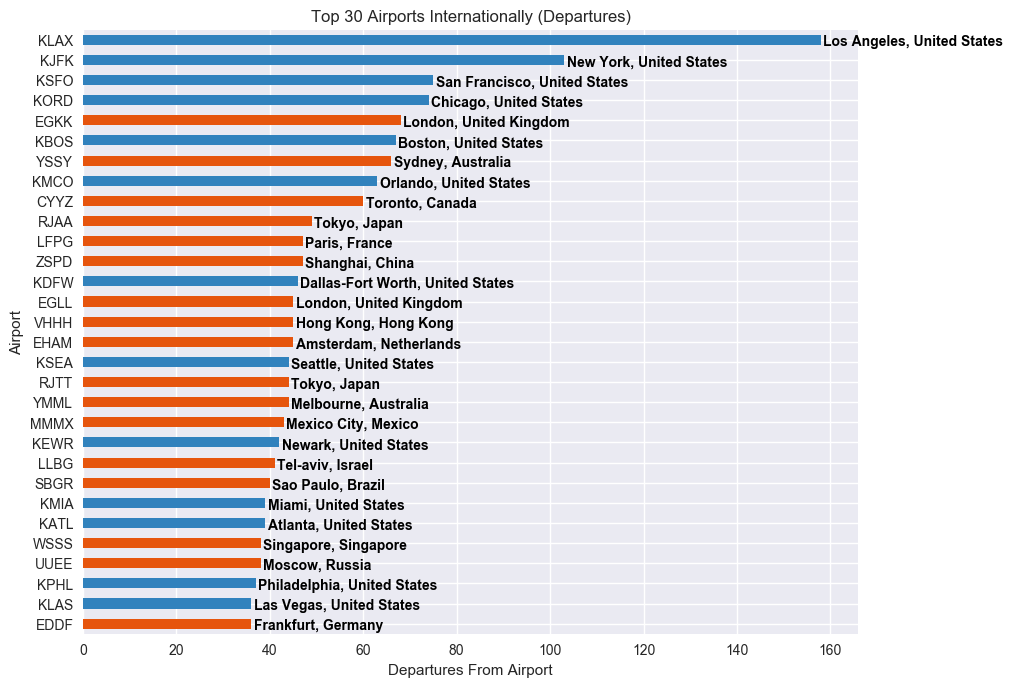

In [29]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh',color=color, title='Top 30 Airports Internationally (Departures)')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .50,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

**Below is a plot of the top 30 international arrival airports.**

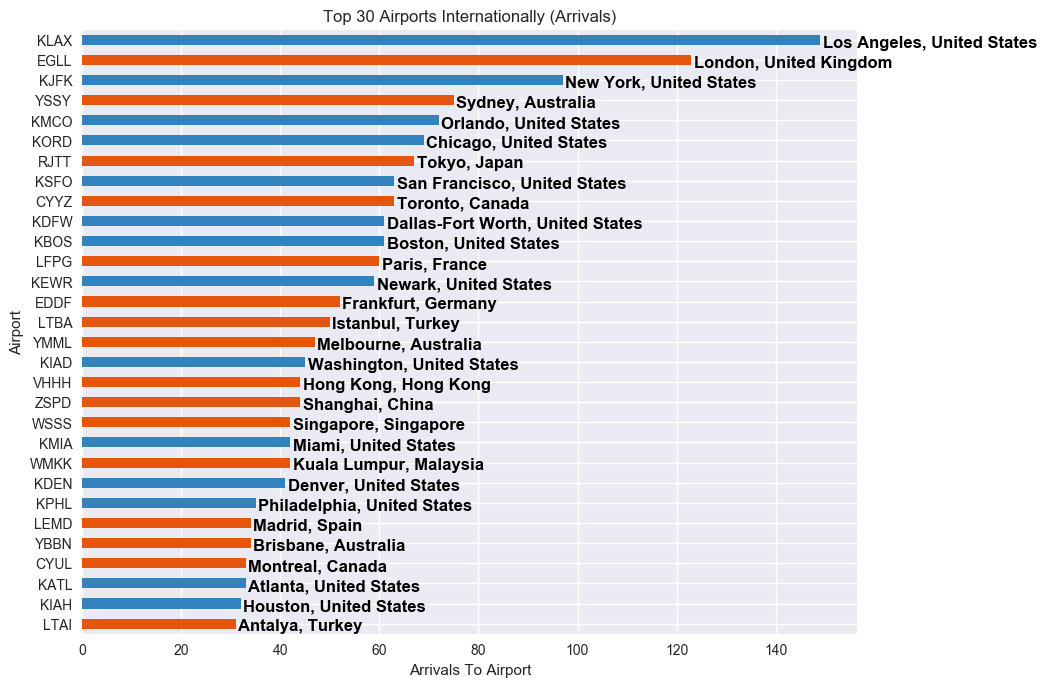

In [30]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh', color=color, title='Top 30 Airports Internationally (Arrivals)')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

# Here is similar data for flights that start or stop in the US

In [32]:
usa_airports = pd.DataFrame()
usa_airports['From'] = day_data_df.groupby(["From"]).Id.nunique()
usa_airports['To'] = day_data_df.groupby(["To"]).Id.nunique()
usa_airports['From'] = usa_airports['From'].fillna(0).map(np.int64)
usa_airports['To'] = usa_airports['To'].fillna(0).map(np.int64)
usa_airports['From (%)'] = usa_airports['From']/usa_airports['From'].sum() * 100
usa_airports['To (%)'] = usa_airports['To']/usa_airports['To'].sum() * 100
usa_airports['Country'] = [country_lu(code) for code in usa_airports.index.values]
usa_airports['Domestic'] = usa_airports.index.isin(us_airports)
usa_airports.index.name = 'Airport'
usa_airports.sort_values(by='To',ascending=False).head(5)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
KLAX,149,158,3.653752,4.306351,United States,True
KJFK,97,103,2.378617,2.807304,United States,True
KSFO,63,75,1.544875,2.044154,United States,True
KORD,69,74,1.692006,2.016898,United States,True
EGKK,16,68,0.392349,1.853366,United Kingdom,False


In [33]:
usa_airports.groupby(usa_airports['Domestic']).sum()

,From,To,From (%),To (%)
Domestic,,,,
False,2584,2249,63.364394,61.297356
True,1494,1420,36.635606,38.702644


The top 30 airports where the destination is in the US.

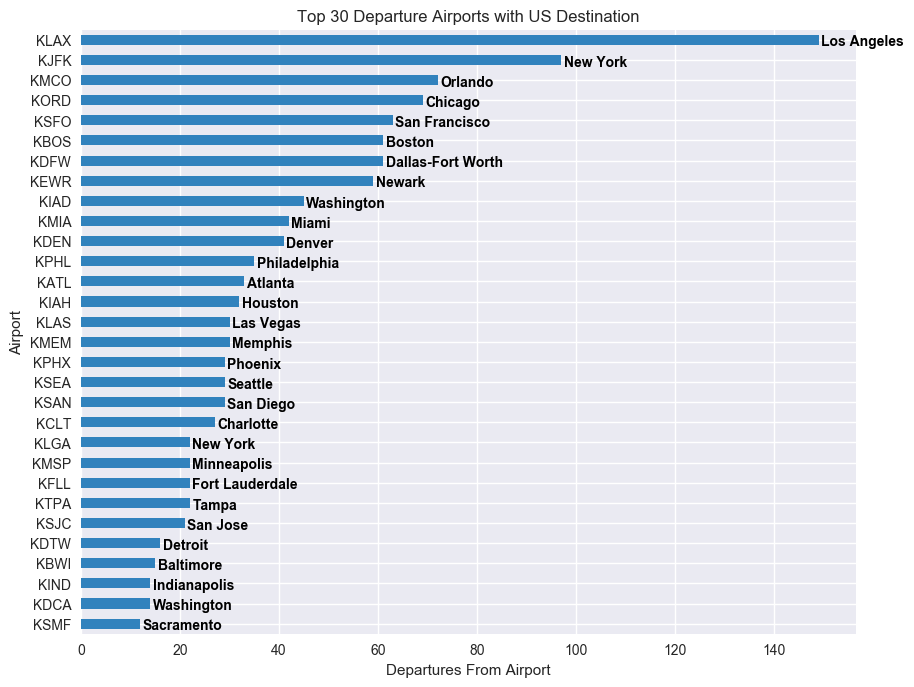

In [34]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.To.index.isin(us_airports)].sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),
                 palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh', color=color, title='Top 30 Departure Airports with US Destination')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

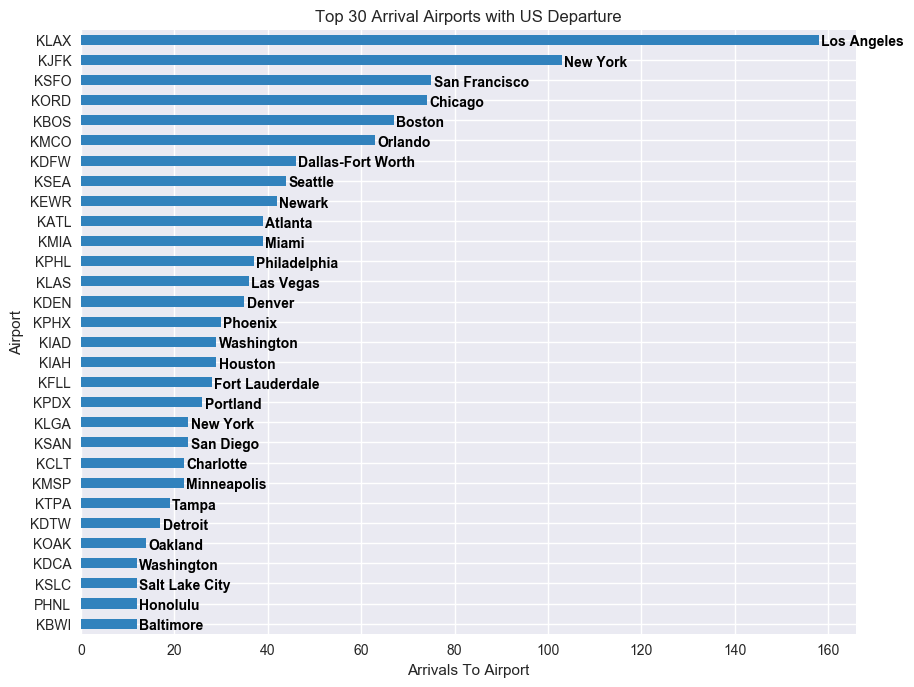

In [35]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.From.index.isin(us_airports)].sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports), palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh',  color=color, title='Top 30 Arrival Airports with US Departure')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

In [36]:
international = usa_airports[~usa_airports.From.index.isin(us_airports)]
international = international[~international.To.index.isin(us_airports)]
international.sort_values(by='From',ascending=False).head(10)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,123,45,3.016184,1.226492,United Kingdom,False
YSSY,75,66,1.839137,1.798855,Australia,False
RJTT,67,44,1.642962,1.199237,Japan,False
CYYZ,63,60,1.544875,1.635323,Canada,False
LFPG,60,47,1.471309,1.281003,France,False
EDDF,52,36,1.275135,0.981194,Germany,False
LTBA,50,29,1.226091,0.790406,Turkey,False
YMML,47,44,1.152526,1.199237,Australia,False
VHHH,44,45,1.078960,1.226492,Hong Kong,False


In [37]:
international_country = international.groupby(international['Country'])
print('Main contries traveled to:\n',', '.join(list(international_country.sum().sort_values(by='To',
                                                                                 ascending=False).head(20).index)))
print('Main countries traveled from:\n', ', '.join(list(international_country.sum().sort_values(by='From',
                                                                                   ascending=False).head(20).index)))

Main contries traveled to:
 United Kingdom, Australia, Japan, China, Canada, Germany, Brazil, Russia, Mexico, France, Turkey, Malaysia, Netherlands, Hong Kong, Israel, Singapore, Italy, Indonesia, Spain, Ireland
Main countries traveled from:
 Australia, China, Spain, Canada, Japan, United Kingdom, Turkey, Mexico, Germany, Russia, Brazil, France, Greece, Italy, Malaysia, Indonesia, Hong Kong, Singapore, Colombia, Taiwan


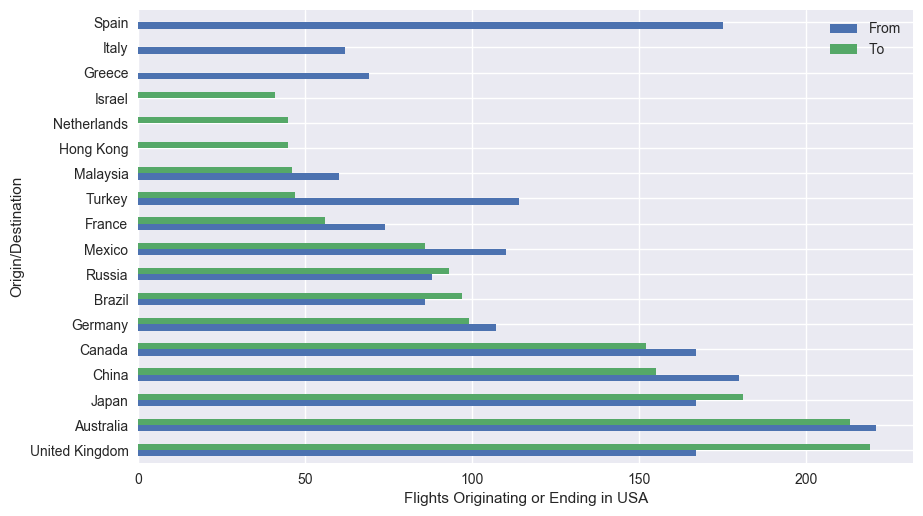

In [38]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['figure.dpi'] = 100
from_ = international_country.sum().sort_values(by='From',ascending=False).head(15)['From']
to_ = international_country.sum().sort_values(by='To',ascending=False).head(15)['To']
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh')
ax.set_xlabel('Flights Originating or Ending in USA')
ax.set_ylabel('Origin/Destination')

And Atlanta...

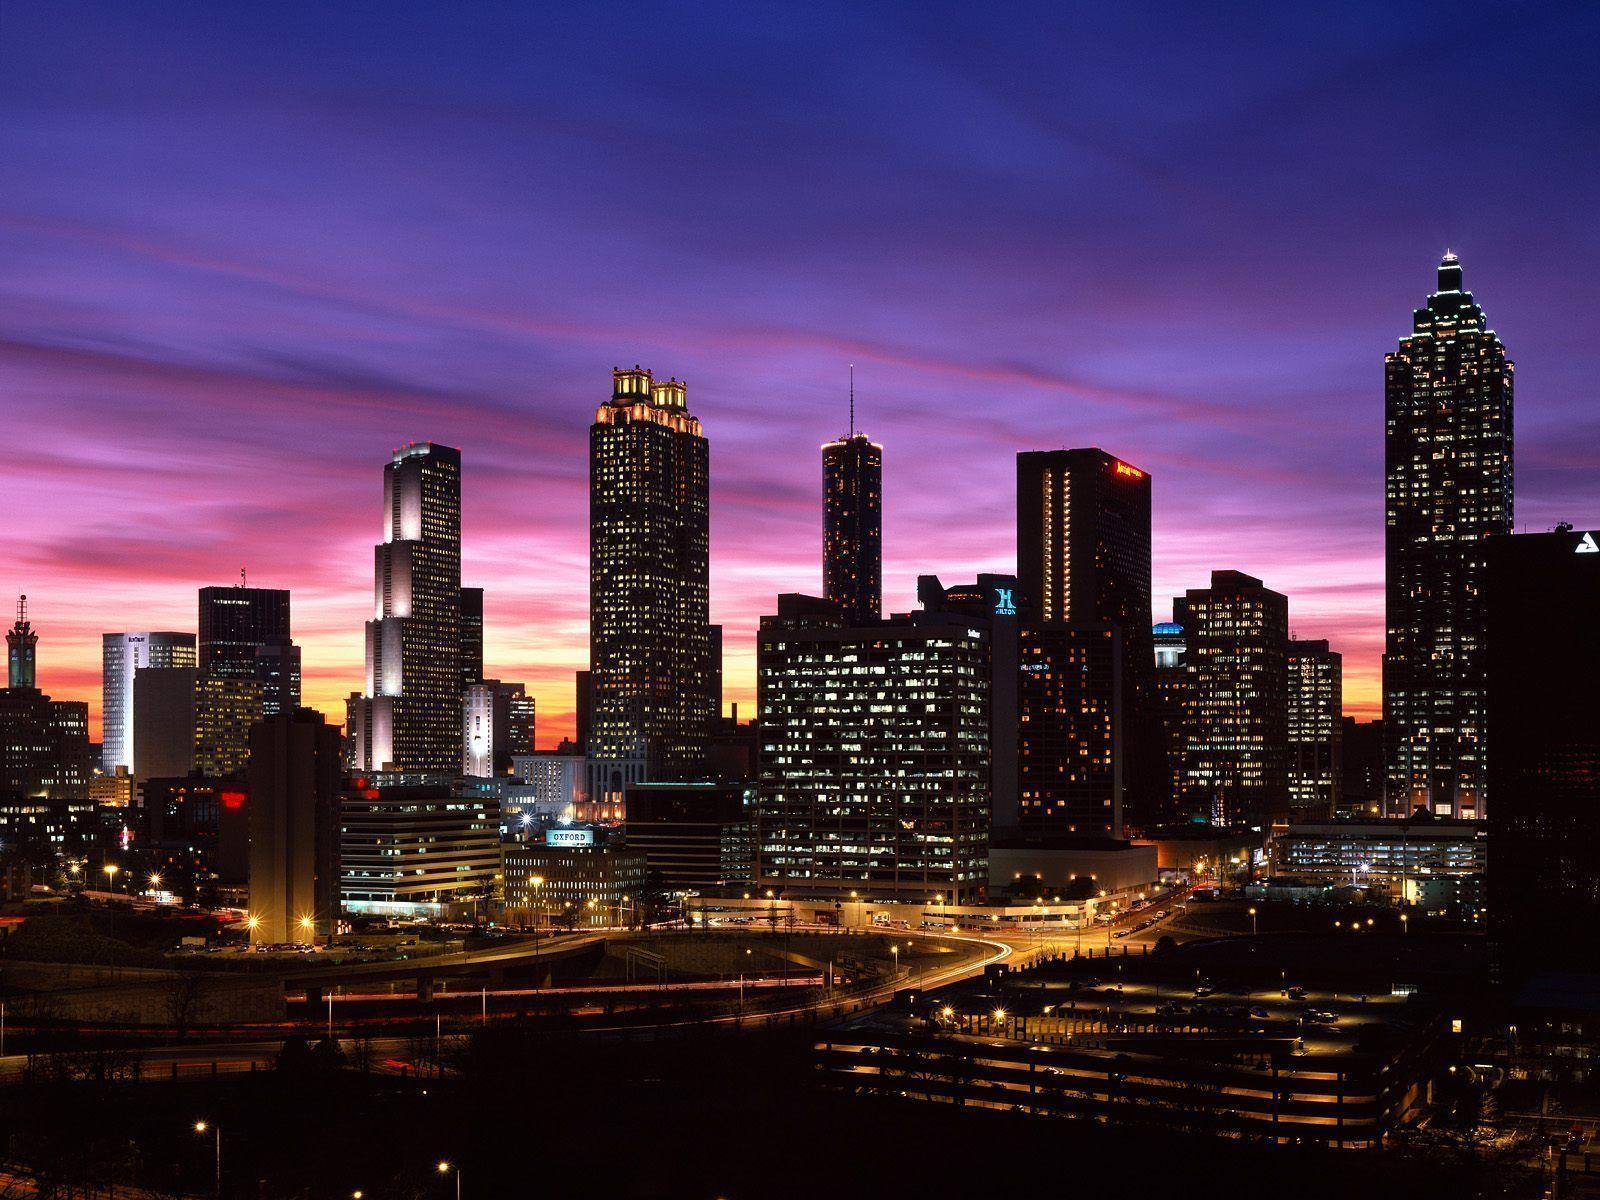

In [119]:
Image("http://wallpapercave.com/wp/E48LtWF.jpg")

In [42]:
mega_data_df.columns

Index(['Icao', 'Lat', 'Long', 'PosTime', 'Man', 'Type'], dtype='object')

In [44]:
atl_ = day_data_df.query('From == "KATL" | To == "KATL"')
atl = pd.DataFrame()
atl['From'] = atl_.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['To'] = atl_.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['From'] = atl['From'].fillna(0).map(np.int64)
atl['To'] = atl['To'].fillna(0).map(np.int64)
atl['From (%)'] = atl['From']/atl['From'].sum() * 100
atl['To (%)'] = atl['To']/atl['To'].sum() * 100
atl['Country'] = [country_lu(code) for code in atl.index.values]
atl.drop('KATL', inplace=True)
atl['Both'] = atl['From'] + atl['To']
atl['Both (%)'] = atl['Both']/atl['Both'].sum() * 100
atl = atl.sort_values(by='Both (%)',ascending=False).head(15)
atl

,From,To,From (%),To (%),Country,Both,Both (%)
To,,,,,,,
KLAX,2,2,3.076923,4.545455,United States,4,10.810811
EGLL,1,2,1.538462,4.545455,United Kingdom,3,8.108108
KSLC,1,2,1.538462,4.545455,United States,3,8.108108
KSFO,2,1,3.076923,2.272727,United States,3,8.108108
EDDF,2,0,3.076923,0.000000,Germany,2,5.405405
KCLT,2,0,3.076923,0.000000,United States,2,5.405405
KMCO,1,1,1.538462,2.272727,United States,2,5.405405
MMMX,1,1,1.538462,2.272727,Mexico,2,5.405405
KONT,1,1,1.538462,2.272727,United States,2,5.405405


In [46]:
day_of_data_df_ATL = day_data_df.query("To == 'KATL' | From == 'KATL'")
ac_in_ATL = pd.pivot_table(day_of_data_df_ATL,values=['Icao'],index=['Man','Type'], 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)

In [47]:
ac_by_man[:10]

,Icao
Man,
Boeing,1823
Airbus,1205
Bombardier,311
Embraer,303
Cessna,73
McDonnell Douglas,55
Piper,50
Avions de Transport Regional,37
Textron Aviation,34
